# Multi Tool path Gen

In [37]:
import csv
import numpy as np
import pandas as pd

###### PARAM ENTRADA ##############
##### ASSUMES THAT UNITS ARE MM####
## AND CSV IS IN MM
vel = 600.0; #mm/min
#THEY ARE USED TO CORRECT INITIAL Z
gap_0       = 0.0e-4
dt_dum      = 1.0e-3 #Positioning
thck        = 5.0e-4

av_dist = 0.9
dt = av_dist  / vel
#NEW, THIS ACCOMODATES TOOL TO ABS Z POSITION
t_interf = 1.0
#### IN TOP TOOL t/2 + disp = zabs
#ZABS IS GIVEN BY TOOLTIP POINTS
#disp = zabs - t/2
###################################
def writeFloatField(number, length, decimals):
    fmt ='%.' + str(decimals) + 'e'
    # print ('format ' + fmt)
    s = fmt % number
    spaces = ''
    for i in range ((int)(length - len(s))):
        spaces = spaces + ' '
    output = spaces + s
    # print (spaces + s)
    return output

def get_InitialXY(fname):
    file = open(fname)
    reader = csv.reader(file)
    data = list(csv.reader(file, delimiter=','))

    ret = (1.0e-3*float (data[1][0]), 1.0e-3*float (data[1][1]))
    print("InitialXY is: ", ret)
    return ret

def multitool_rewrite(fnametop,fnamebot,step_angle=90):
    step_angle
    angles=np.arange(step_angle,360,step_angle)
    print(angles)
    
    data=pd.read_csv(fnametop)
    data2=pd.read_csv(fnamebot)


    data.to_csv(f'multi_tool_{0}.csv',index=False)
    data2.to_csv(f'multi_tool_{1}.csv',index=False)
    
    
    data["radio"] = (data.X**2+data.Y**2)**0.5
    data2["radio"] = (data2.X**2+data2.Y**2)**0.5

    out_top=pd.DataFrame()

    out_bot=pd.DataFrame()

    for i,angle in enumerate(angles):
        #const
        sin=np.sin(angle*np.pi/180)
        cos=np.cos(angle*np.pi/180)
        
        out_top["X"]=cos*data.X-sin*data.Y
        out_top["Y"]=sin*data.X+cos*data.Y
        out_top['Z']=data.Z

        out_bot["X"]=cos*data2.X-sin*data2.Y
        out_bot["Y"]=sin*data2.X+cos*data2.Y
        out_bot['Z']=data2.Z
        
        out_top.to_csv('multi_tool_'+str(i*2+2)+'.csv',index=False)
        out_top.to_csv('multi_tool_'+str(i*2+3)+'.csv',index=False)
        #plt.plot(out_top.X,out_top.Y)
    files=[]
    print(i)
    for k in range(i*2+4):
        print(k)
        files.append(f'multi_tool_{k}.csv')
    
    return files



def convert_multi_tool(filenames, multi_tool_N=2):

####TOP TOOLS################################################################
    for i in range(0,len(filenames),2):
        out_x = open(f'movi_x{i}.inc',"w")
        out_y = open(f'movi_y{i}.inc',"w")
        out_z = open(f'movi_z{i}.inc',"w")

        fname=filenames[i]
        print (fname)
        file = open(fname)
        reader = csv.reader(file)
        data = list(csv.reader(file, delimiter=','))
        pt_count=len(data)-1
        print(data[1][1])
        print("Point Count: ", pt_count)

        funs=[(i*3) + 1 , (i*3) + 2, (i*3) + 3]

        print("top tols",funs)

        s=[f"{num:03d}" for num in funs ]
        
        out_x.write(f"/FUNCT/1000{s[0]}\nmovx\n")
        out_y.write(f"/FUNCT/1000{s[1]}\nmovy\n")
        out_z.write(f"/FUNCT/1000{s[2]}\nmovz\n")

        
        f = 1.0e-3
        x = [float(data[1][0]), float(data[1][1]), float (data[1][2])]
        xo = f * float (data[1][0])
        yo = f * float (data[1][1])
        zo = f * float (data[1][2])
        
        print ("First Point: ", x)
        avg_d=0.0
        t = 0.0    
        
        out_x.write(writeFloatField(t*60.0,20,10) + writeFloatField(0.0,20,10) + "\n")
        out_y.write(writeFloatField(t*60.0,20,10) + writeFloatField(0.0,20,10) + "\n")
        out_z.write(writeFloatField(t*60.0,20,10) + writeFloatField(0.0,20,10) + "\n")
    
        out_x.write(writeFloatField(t_interf,20,10) + writeFloatField(0.0,20,10) + "\n")
        out_y.write(writeFloatField(t_interf,20,10) + writeFloatField(0.0,20,10) + "\n")
        out_z.write(writeFloatField(t_interf,20,10) + writeFloatField(zo-thck/2.0, 20,10) + "\n")
    
        err_count = 0

        for i in range (2, len(data)):
            xp = np.array(data[i-1])
            # x = np.array(data[i])
            # x = np.array([float(data[i][0]), float(data[i][1]), float (data[i][2])])
            x = np.array([float(data[i][0]), float(data[i][1]), float (data[i][2])])
            xp = np.array([float(data[i-1][0]), float(data[i-1][1]), float (data[i-1][2])])
            # xp = data[i-1]
            lst1 = [10,20,30,40,50]
            dist = np.linalg.norm(x-xp)
            avg_d = avg_d + dist
            v = x -xp
            # print ("x xp v dist", x, xp, v, dist)
            # print ("norm" )
            # print (i, data[i][0], data[i][1] ,data[i][2])
            # print (i, x[0], x[1] ,x[2])
            if (dist > 1.0e-6):
                dt = dist/vel
            else:
                err_count +=1
            t = t + dt

            out_x.write(writeFloatField(t*60.0+t_interf,20,10) + writeFloatField(f*x[0] - xo,20,10) + "\n")
            out_y.write(writeFloatField(t*60.0+t_interf,20,10) + writeFloatField(f*x[1] - yo,20,10) + "\n")
            out_z.write(writeFloatField(t*60.0+t_interf,20,10) + writeFloatField(f*x[2]-thck/2.0,20,10) + "\n")
    #    else:
    #        print("WARNING IN POINT"+ str(i)+", DISTANCE LESS THAN 1E-5")
            
        t +=10.0*dt
        out_x.write(writeFloatField(t*60.0+t_interf,20,10) + writeFloatField(f*x[0] - xo, 20,10) + "\n")
        out_y.write(writeFloatField(t*60.0+t_interf,20,10) + writeFloatField(f*x[1] - yo, 20,10) + "\n")
        out_z.write(writeFloatField(t*60.0+t_interf,20,10) + writeFloatField(5.0,20,10) + "\n")
                
        # The type of file is “_io.TextIOWrapper” which is a file object that is returned by the open()
        # type(file)
        avg_d = avg_d/pt_count
        print ("Avg distance: ", avg_d)
        print ("Segments witgh distance > 1.0e-6: ", err_count, " of ", len(data))
        out_x.close,out_y.close,out_z.close


####BOTOM TOOLS################################################################

    for i in range(1,len(filenames),2):

        fname=filenames[i]
        print (fname)
        
        out_x = open(f'movi_x{i}.inc',"w")
        out_y = open(f'movi_y{i}.inc',"w")
        out_z = open(f'movi_z{i}.inc',"w")
    
        file = open(fname)
        reader = csv.reader(file)
        data = list(csv.reader(file, delimiter=','))
        pt_count=len(data)-1

        print (data[1][1])
        print ("Point Count: ", pt_count)

        funs=[(i*3) + 1 , (i*3)+2, (i*3) + 3 ]

        s=[f"{num:03d}" for num in funs ]
        
        print("bot tols",funs)
        
        out_x.write(f"/FUNCT/1000{s[0]}\nmovx\n")
        out_y.write(f"/FUNCT/1000{s[1]}\nmovy\n")
        out_z.write(f"/FUNCT/1000{s[2]}\nmovz\n") 
    


        f = 1.0e-3
        x = [float(data[1][0]), float(data[1][1]), float (data[1][2])]
        xo = f * float (data[1][0])
        yo = f * float (data[1][1])
        zo = f * float (data[1][2])
        
        print("First Point: ", x)
        avg_d=0.0
        t=0.0    
    
        out_x.write(writeFloatField(t*60.0,20,10) + writeFloatField(0.0,20,10) + "\n")
        out_y.write(writeFloatField(t*60.0,20,10) + writeFloatField(0.0,20,10) + "\n")
        out_z.write(writeFloatField(t*60.0,20,10) + writeFloatField(0.0,20,10) + "\n")

        out_x.write(writeFloatField(t_interf,20,10) + writeFloatField(0.0,20,10) + "\n")
        out_y.write(writeFloatField(t_interf,20,10) + writeFloatField(0.0,20,10) + "\n")
        out_z.write(writeFloatField(t_interf,20,10) + writeFloatField(zo+thck/2.0, 20,10) + "\n")
        
        err_count = 0
        
        for i in range (2, len(data)):
            
            x = np.array([float(data[i][0]), float(data[i][1]), float (data[i][2])])
            xp = np.array([float(data[i-1][0]), float(data[i-1][1]), float (data[i-1][2])])

            lst1 = [10,20,30,40,50]
            dist = np.linalg.norm(x-xp)
            avg_d = avg_d + dist
            v = x -xp
            # print ("x xp v dist", x, xp, v, dist)
            # print ("norm" )
            # print (i, data[i][0], data[i][1] ,data[i][2])
            # print (i, x[0], x[1] ,x[2])
            if (dist > 1.0e-6):
                dt = dist/vel
            else:
                err_count +=1        
            t = t + dt

            out_x.write(writeFloatField(t*60.0+t_interf,20,10) + writeFloatField(f*x[0] - xo,20,10) + "\n")
            out_y.write(writeFloatField(t*60.0+t_interf,20,10) + writeFloatField(f*x[1] - yo,20,10) + "\n")
            out_z.write(writeFloatField(t*60.0+t_interf,20,10) + writeFloatField(f*x[2] +thck/2.0,20,10) + "\n")
            #else:
            #    print("ERROR, POINT DISTANCE LESS THAN 1E-5")
            
        t +=10.0*dt
        out_x.write(writeFloatField(t*60.0+t_interf,20,10) + writeFloatField(f*x[0] - xo, 20,10) + "\n")
        out_y.write(writeFloatField(t*60.0+t_interf,20,10) + writeFloatField(f*x[1] - yo, 20,10) + "\n")
        out_z.write(writeFloatField(t*60.0+t_interf,20,10) + writeFloatField(-5.0,20,10) + "\n")
                
        # The type of file is “_io.TextIOWrapper” which is a file object that is returned by the open()
        # type(file)
        avg_d = avg_d/pt_count
        print ("Avg distance: ", avg_d)
        print ("Segments witgh distance > 1.0e-6: ", err_count, " of ", len(data))
        out_x.close,out_y.close,out_z.close



In [38]:
#funnames=[]

#mult_tool_N=8
#for i in range(multi_tool_N)
#    funname.append(f'movi_x{i}.inc')
#    funname.append(f'movi_y{i}.inc')
#    funname.append(f'movi_z{i}.inc')

# import pandas as pd
# import numpy as np
# step_angle=90
# angles=np.arange(90,360,step_angle)
# print(angles)

# data=pd.read_csv("data/multitool_topToolTipPnts.csv")

# for angle in angles:
#     #const
#     sin=np.sin(angle*np.pi/180)
#     cos=np.cos(angle*np.pi/180)
#     data["radio"] = (data.X**2+data.Y**2)**0.5
#     data["X"+str(angle)]=cos*data.radio
#     data["Y"+str(angle)]=sin*data.radio

# data.head()

In [39]:
files=multitool_rewrite("data/multitool_topToolTipPnts.csv","data/multitool_botToolTipPnts.csv",step_angle=90)
convert_multi_tool(files,multi_tool_N=8)

[ 90 180 270]
2
0
1
2
3
4
5
6
7
multi_tool_0.csv
-0.0
Point Count:  3115
top tols [1, 2, 3]
First Point:  [42.3531, -0.0, -0.0209]
Avg distance:  0.9551299555633491
Segments witgh distance > 1.0e-6:  21  of  3116
multi_tool_2.csv
42.3531
Point Count:  3115
top tols [7, 8, 9]
First Point:  [2.593379417448388e-15, 42.3531, -0.0209]
Avg distance:  0.9551299555633493
Segments witgh distance > 1.0e-6:  21  of  3116
multi_tool_4.csv
5.186758834896776e-15
Point Count:  3115
top tols [13, 14, 15]
First Point:  [-42.3531, 5.186758834896776e-15, -0.0209]
Avg distance:  0.9551299555633491
Segments witgh distance > 1.0e-6:  21  of  3116
multi_tool_6.csv
-42.3531
Point Count:  3115
top tols [19, 20, 21]
First Point:  [-7.780138252345163e-15, -42.3531, -0.0209]
Avg distance:  0.9551299555633491
Segments witgh distance > 1.0e-6:  21  of  3116
multi_tool_1.csv
-0.0
Point Count:  3115
bot tols [4, 5, 6]
First Point:  [42.7308, -0.0, -0.5067]
Avg distance:  1.1133216037627482
Segments witgh distance > 1

# ADSIF_GEN

In [40]:
#https://www.tutorialsteacher.com/python/create-ui-using-tkinter-in-python
from math import *
from mesher import *
import numpy as np
import csv
import sys

# from tkinter import *
# from tkinter.ttk import Combobox
from enum import Enum

# window=Tk()
linea_g=10

flog = open("log.txt","w")

#################### INPUT VARS

#WORKPIECE
largo = 0.1
delta = 0.0025
thck  = 5.0e-4      #Plate Thickness
thck_rig = 1.0e-4   #BALL
thck_supp = 1.0e-4  #SUPP

#TOOL (IF CALC PATH)
r_i           = 0.0     #Inner Path Radius
r_o           = 0.0     #Outer Path Radius

#TOOL (IT NOT CALC PATH)
topfname = "myToolpath_topToolTipPnts.csv"
botfname = "myToolpath_botToolTipPnts.csv"



mm       = 1.0e-3 #IF UNITS ARE IN MM

r             = 0.0325
dr            = 5.0e-4    #DESAPARECE DE ACUERDO A LA GEOMETRIA
dt            = 1.0e-5    #Time increment for path gen
#t_ang         = 1.0e-3    #Periodo angular, ANTES ERA CONSTANTE
p_D           = 2.5e-3     #ASDIF RADIAL DISTANCE BETWEEN TOOLS
p_S           = 4.3e-4     #ASDIF HEIGHT DISTANCE BETWEEN TOOLS
tool_speed    = 0.6 / 60.0 * 5000 #600mm/min according to Valoppi
t_ind         = 1.0e-3
tool_rad      = 0.0025    #Tool radius
gap           = 0.0e-4
gap_cont      = -2.2e-4
dtout         = 1.0
dtout_his     = 1.0
end_time      = 2405.0
v_supp        = 1.0e-3
supp_rel_time = 10.0
supp_vel_ramp = True
dynrel_time   = 5.0
## SCALING
vscal_fac     = 1.0 #Affects All magnitudes with s^-1: Tool Speed, HEAT CONDUCTIVIY, CONVECTION
dampfac       = 100.0

###### SUPPORT
dens_supp_1 = 5
dens_supp_2 = 60
largo_supp = 0.005

###### CENTER OF PIECE 
x_init              = r_i  #DO NOT PUT xo! USED AS x OUTPUT IN DOUBLE SIDED
x_init_o            = r_o  #DO NOT PUT xo! USED AS x OUTPUT IN DOUBLE SIDED
move_tool_to_inipos = True # THIS IS CONVENIENT, OTHERWISE RADIOSS THROWS ERROR DUE TO LARGE DISP TO INITIAL POS
                           #ONLY USED IF NOT CALC PATH
thermal             = False
cont_support        = True       #TRUE: SUPPORT IS MODELED BY CONTACT, FALSE: SUPPORT IS MODELED BY BCS ON NODES
double_sided        = True
calc_path           = False
mass_scal           = True
ms_dtsize           = 1.0e-4

multi_tool          = True
multi_tool_stp_angle= 90
multi_tool_N        = 8 

if multi_tool:
    topfname = "data/multitool_topToolTipPnts.csv"
    botfname = "data/multitool_botToolTipPnts.csv"


###### MATERIAL
mat = Material(1,thermal) #ID, THERMAL
mat.rho     = 4430.0
mat.E       = 105.0e9
mat.nu      = 0.34
mat.vs_fac  = vscal_fac

#thermal
mat.k_th  = 7.4 # 15 //
mat.cp_th = 520.0

mat.Ajc   = 790.0e6
mat.Bjc   = 478.0e6
mat.njc   = 0.28
mat.mjc   = 1.0
mat.Cjc   = 0.032
mat.e0jc  = 1.0

##### SCALING
# class Scaling(Enum):
  # NONE   = 1       # 
  # VPROC  = 2       #Only on tool veloc 
  # MS_FIX = 3       #Fixed Mass scal, since cp 
  # VS_FIX = 4
  # AMS    = 5

# scal_type = Scaling.MS_FIX
# scal_fac  = 250.0          #ONLY WORKS WITH FIXE MS OR VS 

################################################## BEGIN ####################################################################################
#############################################################################################################################################
# if (scal_type == Scaling.NONE or scal_type == Scaling.VPROC or scal_type == Scaling.AMS):
  # scal_fac = 1.0

# filelbl = Label(window, text="Input File", width=15,justify=LEFT)
# filelbl.grid(column=1, row=0)	
# textField = Entry(window, width=15)
# textField.grid(column=2, row=0)
# textField.insert(0,"test")

if (not calc_path):
  try:
    print ("Reading Tool Path files to position tool")
    print (topfname + ", " + topfname)
    topf = open(topfname) #IN
    botf = open(botfname) #OUT
    topdata = list(csv.reader(topf, delimiter=','))
    botdata = list(csv.reader(botf, delimiter=','))

    xy_i = [float(topdata[1][0])*mm,float(topdata[1][1])*mm]
    xy_o = [float(botdata[1][0])*mm,float(botdata[1][1])*mm]

    print ("Top    Init X and Y positions: ", xy_i[0],xy_i[1])
    print ("Bottom Init X and Y positions: ", xy_o[0],xy_o[1])  
  except IOError:
    print('There was an error opening the toolpaths files!')
    #return
    sys.exit()

test = [(1,1),(2,2)]
test.append((3,4))
print (test)
print (test[2][0])



supp_mesh = []
supp_part = []

shell_elnod = [(1,2,3,4)]


shell_mesh = Plane_Mesh(1,largo,delta)
if (calc_path):
  y_init = 0.0
  y_init_o = 0.0
  if (not move_tool_to_inipos):
    x_init   = 0.0  
    x_init_o = 0.0  
else:
  x_init=xy_i[0]     
  y_init=xy_i[1]
  x_init_o=xy_o[0]  
  y_init_o=xy_o[1]
  
sph1_mesh = Sphere_Mesh(2, tool_rad,        \
                        x_init, y_init_o,(tool_rad + thck/2.0 + gap + thck_rig/2.0), \
                                        8) #(id, radius, divisions):

if (double_sided):
  sph2_mesh = Sphere_Mesh(3, tool_rad,        \
                        x_init_o, y_init_o,(-tool_rad - thck/2.0 - gap-thck_rig/2.0), \
                                        8) #(id, radius, divisions):


i=0
#============================================================================================================
if multi_tool:

    sph_mesh=list()
    
    angles=list(np.arange(multi_tool_stp_angle,360,multi_tool_stp_angle))
    print("angulos", angles)

    r_init_top=np.sqrt(x_init**2 + y_init**2)
    r_init_bot=np.sqrt(x_init_o**2 + y_init_o**2)
    
    for i,angle in  enumerate(angles):
        sin=np.sin(angle*np.pi/180)
        cos=np.cos(angle*np.pi/180)

        sph_mesh.append(Sphere_Mesh(3+(i*2+1), tool_rad,        \
                                cos * r_init_top, sin * r_init_top, (tool_rad + thck/2.0 + gap + thck_rig/2.0),\
                                8)#(id, radius, divisions): \
                       )
        
        sph_mesh.append(Sphere_Mesh(3+(i*2+2), tool_rad,        \
                                cos * r_init_bot, sin * r_init_bot,(-tool_rad - thck/2.0 - gap-thck_rig/2.0), \
                                8) #(id, radius, divisions):\
                       )

    
    else:
        i=0

#============================================================================================================

                                        

if (cont_support):
  #Y-     support,                id,lx,               ly,         elem_x,     elem_y,       ox,                   oy, z_, flip):
  supp_mesh.append(Rect_Plane_Mesh(2+multi_tool_N,largo+largo_supp,largo_supp,dens_supp_2,dens_supp_1, -largo/2.0-largo_supp/2.0, -largo/2.0-largo_supp/2.0, -thck/2.0-gap_cont-thck_supp/2.0, False)) #Legth x,  
  supp_mesh[0].AddRigidNode(0.0,-largo/2.0, -2.0*thck)
  supp_mesh.append(Rect_Plane_Mesh(3+multi_tool_N,largo+largo_supp,largo_supp,dens_supp_2,dens_supp_1, -largo/2.0-largo_supp/2.0, -largo/2.0-largo_supp/2.0,  thck/2.0+gap_cont+thck_supp/2.0, True))
  supp_mesh[1].AddRigidNode(0.0,-largo/2.0,  2.0*thck)

  #Y+ support,                   id,lx,               ly,         elem_x,     elem_y,       ox,                   oy, z_, flip):
  supp_mesh.append(Rect_Plane_Mesh(4+multi_tool_N,largo+largo_supp,largo_supp,dens_supp_2,dens_supp_1, -largo/2.0-largo_supp/2.0,  largo/2.0-largo_supp/2.0, -thck/2.0-gap_cont-thck_supp/2.0, False))
  supp_mesh[2].AddRigidNode(0.0, largo/2.0, -2.0*thck)
  supp_mesh.append(Rect_Plane_Mesh(5+multi_tool_N,largo+largo_supp,largo_supp,dens_supp_2,dens_supp_1, -largo/2.0-largo_supp/2.0,  largo/2.0-largo_supp/2.0,  thck/2.0+gap_cont+thck_supp/2.0, True))
  supp_mesh[3].AddRigidNode(0.0, largo/2.0,  2.0*thck)
  
  #THESE SUPPORTS HAVE Y LENGTH SHORTER THAN OTHERS; ONLY Y LENGTH ON HEIGHT
  # #X-     support,                id,lx,      ly,     elem_x,     elem_y,       ox,               oy, z_, flip):  
  x_pos = largo/2.0
  supp_mesh.append(Rect_Plane_Mesh(6+multi_tool_N,largo_supp,largo-largo_supp,dens_supp_1,dens_supp_2, -x_pos-largo_supp/2.0, -largo/2.0+largo_supp/2.0, -thck/2.0-gap_cont-thck_supp/2.0, False))
  supp_mesh[4].AddRigidNode(-largo/2.0 ,0.0,  -2.0*thck)
  supp_mesh.append(Rect_Plane_Mesh(7+multi_tool_N,largo_supp,largo-largo_supp,dens_supp_1,dens_supp_2, -x_pos-largo_supp/2.0, -largo/2.0+largo_supp/2.0,  thck/2.0+gap_cont+thck_supp/2.0, True))
  supp_mesh[5].AddRigidNode(-largo/2.0 ,0.0,   2.0*thck)

  # #X+     support,                id,lx,      ly,     elem_x,     elem_y,       ox,               oy, z_, flip):  
  supp_mesh.append(Rect_Plane_Mesh(8+multi_tool_N,largo_supp,largo-largo_supp,dens_supp_1,dens_supp_2, x_pos-largo_supp/2.0, -largo/2.0+largo_supp/2.0, -thck/2.0-gap_cont-thck_supp/2.0, False))
  supp_mesh[6].AddRigidNode(-largo/2.0 ,0.0,  -2.0*thck)
  supp_mesh.append(Rect_Plane_Mesh(9+multi_tool_N,largo_supp,largo-largo_supp,dens_supp_1,dens_supp_2, x_pos-largo_supp/2.0, -largo/2.0+largo_supp/2.0,  thck/2.0+gap_cont+thck_supp/2.0, True))
  supp_mesh[7].AddRigidNode(-largo/2.0 ,0.0,   2.0*thck)



  
print("Piece Shell node count", len(shell_mesh.nodes))
# print("Shell Shell node count", len(sph1_mesh.nodes))

print("Shell node count: ", shell_mesh.node_count)

print("Sphere 1 node count", sph1_mesh.node_count)

if (double_sided):
    print("Sphere 2 node count:", sph2_mesh.node_count)

if (multi_tool):
    for k,sph in enumerate (sph_mesh):
        #print("extra tool k")
        print(f"extr {k} sphere node count: {sph.node_count}")



# print("Shell node count", len(shell_mesh.elnod))
# print("Shell node count", len(sph1_mesh.elnod))

model = Model()
model.set_Multi_tool(multi_tool_N)
model.end_proc_time = end_time
model.double_sided = double_sided
print ("Model size: ", len(model.part))
shell = Part(1)
shell.AppendMesh(shell_mesh) 
model.vscal_fac = vscal_fac

model.mass_scal = mass_scal
model.ms_dtsize = ms_dtsize 
model.dampfac   = dampfac

bcpos = largo/2.0 - largo_supp

sph1_pt = Part(2)
sph1_pt.AppendMesh(sph1_mesh) 
sph1_pt.is_rigid = True
sph1_pt.is_moving = True
sph1_pt.asignPropID(2)

if (double_sided):
  sph2_pt = Part(3)
  sph2_pt.AppendMesh(sph2_mesh) 
  sph2_pt.is_rigid = True
  sph2_pt.is_moving = True
  sph2_pt.asignPropID(2)
    
#============================================================================
if (multi_tool):
    sph_pts = list()
    for i in range(multi_tool_N-2):
        print(f'add extra tool {i} to part {i+4}')
        sph_pts.append(Part(4+i))
        sph_pts[i].AppendMesh(sph_mesh[i]) 
        sph_pts[i].is_rigid = True
        sph_pts[i].is_moving = True
        sph_pts[i].asignPropID(2)
else:
    i=0
print ("========================================================")
#print ("tools added model size: ", len(model.part))
#============================================================================

model.AppendPart(shell) #FIRST PART TO ADD!

model.AppendPart(sph1_pt)
if (double_sided):
  model.AppendPart(sph2_pt)

if (multi_tool):
    for sph_pt in sph_pts:
        model.AppendPart(sph_pt)

if (cont_support):
  for sp in range (2*4):
    supp_part.append(Part(5+i+sp))
    print(f'add support {sp} to part {5+i+sp}')
    supp_part[sp].AppendMesh(supp_mesh[sp])
    supp_part[sp].is_rigid = True #REMEMBER LAST NODE OF THE PART IS THE PIVOT
    supp_part[sp].asignPropID(3)
    print("support part length", len(supp_part))
    model.AppendPart(supp_part[sp])

if (not cont_support):
  model.AddNodeSetOutsideBoxXY(1000,Vector(-bcpos,-bcpos,0.0), Vector(bcpos,bcpos,0.0)) #id, v1, v2):



model.AppendMat(mat)
model.AppendProp(Prop(1,thck))

model.AppendProp(Prop(2,thck_rig))

model.AppendProp(Prop(3,thck_supp))

#BALLS AND PLATE
inter_1 = Interface(2,1)
model.AppendInterface(inter_1)

if (double_sided):
  inter_2 = Interface(3,1)
  model.AppendInterface(inter_2)

#Multi - tool
if (multi_tool):

    inter_N=list()
    for index,i in enumerate(range(4,multi_tool_N+2)):
        print ("---------------------------------------------interface ", index, ", ", i)
        inter_N.append(Interface(i,1))
        model.AppendInterface(inter_N[index])
else:
    i=0

#CHANGE TO ARRAY
if (cont_support):
  for sp in range (2*4):
    model.AppendInterface(Interface(sp+multi_tool_N+1+1,1))

model.cont_support = cont_support



#if (thermal):
#  model.part[0].mesh[0].print_segments = True #THERMAL SEGMENTS, RESERVED IDS TO PARTS

if (thermal):
  model.thermal = True

# THERMAL
#for e in range (model.part[0].mesh[0].elem_count):
  #lf = Function(0.0,.0,0)
  #model.AppendLoadFunction (lf)
# sphere_mesh = Sphere_Mesh(2,1.0, 10,1) #(self, id, radius, divisions, ininode):

# shell_mesh.printRadioss("radioss.rad")

# sphere_mesh.printRadioss("radioss.rad")

#IMPORTANTE: LA VELOCIDAD SE ASUME PARA RADIO CONSTANTE EN CADA VUELTAS
#CON LO CUAL EN LA REALIDAD DISMINUYE UN POCO
# def save(lin):

if (calc_path):
# f= open(textField.get(),"w+")
  # LA HERRAMIENTA INTERNA ESTA EN EL TOP, LA EXTERNA EN EL BOTTOM
  # PERO TOP Y BOTTOM CONFUNDE POR LAS INDENTACIONES
  fi_x = open("movi_x.inc","w")
  fi_y = open("movi_y.inc","w")
  fi_z = open("movi_z.inc","w")

  if (double_sided):  
    fo_x = open("movo_x.inc","w")
    fo_y = open("movo_y.inc","w")
    fo_z = open("movo_z.inc","w")

  fi_x.write("/FUNCT/1000001\nmovx\n")    
  fi_y.write("/FUNCT/1000002\nmovy\n")      
  fi_z.write("/FUNCT/1000003\nmovz\n")    

  if (double_sided):
    fo_x.write("/FUNCT/1000004\nmovx\n")    
    fo_y.write("/FUNCT/1000005\nmovy\n")      
    fo_z.write("/FUNCT/1000006\nmovz\n")
  
  t = 0.0
  r = r_i
  turn = 1
  
  z  = 0.0 
  # zo = -thck #ESTA HERRAMIENTA NO DESCIENDE (PARA EVITAR DEFORMACIONES IRREGULARES)
  # zi =  thck 
  zo = zi = 0
  vz = (thck + p_S) / t_ind # EN PRINCIPIO S EDESPLAZA SOLO LA INTERIOR 
  
  #####################INDENTACION ######################### 
  xi = r - p_D/2.0
  xo = r + p_D/2.0
  
  while (t < t_ind):    
    if (move_tool_to_inipos):
      xo -= x_init
      xi -= x_init

    zi -= vz * dt
    #HAY QUE VER SI ES NECESARIO ESCRIBIR X E Y PARA TODOS LOS TIEMPOS
    fi_x.write(writeFloatField(t,20,6) + writeFloatField(xi,20,6) + "\n")
    fi_y.write(writeFloatField(t,20,6) + writeFloatField(0.,20,6) + "\n")
    fi_z.write(writeFloatField(t,20,6) + writeFloatField(zi,20,6) + "\n")
    
    if (double_sided):
      fo_x.write(writeFloatField(t,20,6) + writeFloatField(xo,20,6) + "\n")
      fo_y.write(writeFloatField(t,20,6) + writeFloatField(0.,20,6) + "\n")
      fo_z.write(writeFloatField(t,20,6) + writeFloatField(zo,20,6) + "\n")
    
    # fo_x.write("%.6e, %.6e\n" % (t,xo))
    # fo_y.write("%.6e, %.6e\n" % (t,0.0))
    # fo_z.write("%.6e, %.6e\n" % (t,zo))  
    t +=dt 
 
  print("Final zi %.3e , zo %.3e \n" %(zi,zo))
  
  ######################## VUELTAS ##############################
  while (t < end_time):
    t_ang = 2.0 * pi * r / tool_speed #Tiempo (incremento) de cada vuelta (ASUMIENDO RADIO CONSTANTE)
    print("Turn %d Turn Time %.3e Time %.3e Radius %.3e\n" %(turn, t_ang,t,r))
    t_vuelta = t + t_ang  #Tiempo de final de vuelta (TOTAL)
    t_0 = t               #Tiempo de comienzo de vuelta
    t_inc = 0.0           # t - t_0
    dz = dr               #CAMBIAR SEGUN GEOMETRIA
    vz = dz / t_ang
    while (t < t_vuelta): #VUELTAS  
      # print ("t_inc %.3e t_ang %.3e"%(t_inc,t_ang))
      xi = (r - p_D/2.0 + dr * t_inc/t_ang) *cos(2.0*pi*t_inc/t_ang)
      yi = (r - p_D/2.0 + dr * t_inc/t_ang) *sin(2.0*pi*t_inc/t_ang)
      zi -= vz * dt

      xo = (r + p_D/2.0 + dr * t_inc/t_ang) *cos(2.0*pi*t_inc/t_ang)
      yo = (r + p_D/2.0 + dr * t_inc/t_ang) *sin(2.0*pi*t_inc/t_ang)      
      zo -= vz * dt #CAMBIAR A DZ
      
      # print("zi %.3e , zo %.3e \n" %(zi,zo))
      # z -= t_inc/t_ang * dr # CAMBIAR A dz
      
      fi_x.write(writeFloatField(t,20,6) + writeFloatField(xi,20,6) + "\n")
      fi_y.write(writeFloatField(t,20,6) + writeFloatField(yi,20,6) + "\n")
      fi_z.write(writeFloatField(t,20,6) + writeFloatField(zi,20,6) + "\n")
      if (double_sided):
        fo_x.write(writeFloatField(t,20,6) + writeFloatField(xo,20,6) + "\n")
        fo_y.write(writeFloatField(t,20,6) + writeFloatField(yo,20,6) + "\n")
        fo_z.write(writeFloatField(t,20,6) + writeFloatField(zo,20,6) + "\n")
      
      # fo_x.write("%.6e, %.6e\n" % (t,xo))
      # fo_y.write("%.6e, %.6e\n" % (t,yo))
      # fo_z.write("%.6e, %.6e\n" % (t,zo))
      
      t_inc +=dt
      t += dt


#      if (thermal):
#        e = model.part[0].mesh[0].findNearestElem(xi,yi,zi)
#        flog.write ("TIME %f, pos: %.6e %.6e, Found %d\n" % (t, xi, yi, e ))
#        coord = str (model.part[0].mesh[0].elcenter[e].components)
#        flog.write ("baricenter: %s\n" %(coord))  
#        model.load_fnc[e].Append(t,1.0e6)
      
    r +=dr
    turn += 1    

  #SPRINGBACK
  
  fi_x.close;fi_y.close;fi_z.close
  if (double_sided):
    fo_x.close;fo_y.close;fo_z.close

              #filename, name, id, init_time, veloc):

f_upper_supp = Function(1000007+int(multi_tool_N*3),0.0,0.0) 
f_upper_supp.Append(end_time, 0.0)
if (not supp_vel_ramp):
  f_upper_supp.Append(end_time+1.0e-4, v_supp)
f_upper_supp.Append(end_time+supp_rel_time, v_supp)
#f_upper_supp.Append(end_time+supp_rel_time+1.0e-4,  10.0*v_supp)
#f_upper_supp.Append(end_time+supp_rel_time+1.0e-4+dynrel_time,      10.0*v_supp)
f_upper_supp.Append(end_time+supp_rel_time+dynrel_time,      10.0*v_supp)
model.supp_fnc.append(f_upper_supp)

tool_count = 1
if (double_sided):
  tool_count = 2

if (multi_tool):
    tool_count = multi_tool_N

for p in range(tool_count):
  model.part[p+1].temp_fnc.Append(1.0e-3, 500.)
  model.part[p+1].temp_fnc.Append(end_time+supp_rel_time+dynrel_time, 500.)

#OLD; TEMP IN NODES  
#for e in range (model.part[0].mesh[0].elem_count):  
#  model.load_fnc[e].Append(1.0e3,0.0)



# for e in range (10):
  # # for f in range (len(load_function[e])):
  # for f in range (model.load_fnc[e].val_count):
    # print ("Load Fnction ", e, model.load_fnc[e].getVal(f))
  

model.printRadioss("test")

model.printEngine(1, end_time,dtout, dtout_his)
model.printRelease(2, end_time+supp_rel_time,dtout, dtout_his)
model.printDynRelax(3,end_time+supp_rel_time+dynrel_time,dtout, dtout_his)
# #Si no se coloca lambda no funciona
# b = Button(window, text="Generate", width=10, command=lambda:save(linea_g))
# b.grid(column=3, row=10)
# #b.pack()

# window.title('Incremental Forming PATH Script')
# window.geometry("400x200+10+10")
# window.mainloop()






Reading Tool Path files to position tool
data/multitool_topToolTipPnts.csv, data/multitool_topToolTipPnts.csv
Top    Init X and Y positions:  0.0423531 -0.0
Bottom Init X and Y positions:  0.042730800000000006 -0.0
[(1, 1), (2, 2), (3, 4)]
3
Nodes Count: 1681
Elem Count: 1681
Writing centers 
Creating Sphere mesh
repeated nodes:  100
Sphere Origin:  0.0423531 -0.0 0.0028
Sphere generated: %d 386  nodes      
Creating Sphere mesh
repeated nodes:  100
Sphere Origin:  0.042730800000000006 -0.0 -0.0028
Sphere generated: %d 386  nodes      
angulos [90, 180, 270]
Creating Sphere mesh
repeated nodes:  100
Sphere Origin:  2.593379417448388e-18 0.0423531 0.0028
Sphere generated: %d 386  nodes      
Creating Sphere mesh
repeated nodes:  100
Sphere Origin:  2.6165068722502865e-18 0.042730800000000006 -0.0028
Sphere generated: %d 386  nodes      
Creating Sphere mesh
repeated nodes:  100
Sphere Origin:  -0.0423531 5.186758834896776e-18 0.0028
Sphere generated: %d 386  nodes      
Creating Sphere 

import matplotlib.pyplot as plt
def multitool_rewrite(fnametop,fnamebot,step_angle=90):
    step_angle
    angles=np.arange(step_angle,360,step_angle)
    print(angles)
    
    data=pd.read_csv(fnametop)
    data2=pd.read_csv(fnamebot)


    data.to_csv(f'multi_tool_{0}.csv',index=False)
    data2.to_csv(f'multi_tool_{1}.csv',index=False)
    
    
    data["radio"] = (data.X**2+data.Y**2)**0.5
    data2["radio"] = (data2.X**2+data2.Y**2)**0.5

    #plt.plot(data.radio)

    out_top=pd.DataFrame()

    out_bot=pd.DataFrame()

    #plt.plot(data.X,data.Y)

    for i,angle in enumerate(angles):
        #const
        sin=np.sin(angle*np.pi/180)
        cos=np.cos(angle*np.pi/180)
        
        out_top["X"]=cos*data.X-sin*data.Y
        out_top["Y"]=sin*data.X+cos*data.Y
        out_top['Z']=data.Z

        out_bot["X"]=cos*data2.X-sin*data2.Y
        out_bot["Y"]=sin*data2.X+cos*data2.Y
        out_bot['Z']=data2.Z
        
        out_top.to_csv('multi_tool_'+str(i*2+2)+'.csv',index=False)
        out_top.to_csv('multi_tool_'+str(i*2+3)+'.csv',index=False)
        #plt.plot(out_top.X,out_top.Y)

    files=[]
    print(i)
    for k in range(i*2+4):
        print(k)
        files.append(f'multi_tool_{k}.csv')
    
    return files

files=multitool_rewrite("data/multitool_topToolTipPnts.csv","data/multitool_botToolTipPnts.csv",step_angle=45)

[ 45  90 135 180 225 270 315]
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


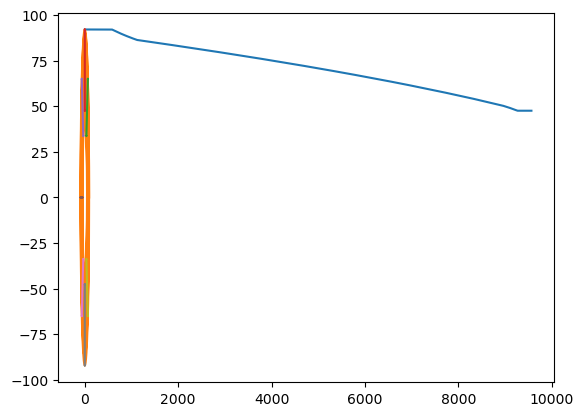

In [17]:
files=multitool_rewrite("data/multitool_topToolTipPnts.csv","data/multitool_botToolTipPnts.csv",step_angle=45)

NameError: name 'data' is not defined